### Predictive Modelling of Distillation Column using Machine Learning

Process engineering is a subfield of chemical engineering that designs and optimizes chemical processes to turn raw materials into useful products. In an effort to monitor chemical process, vast amounts of data are collected, which enables the use of machine learning to identify anomalies, optimize processes, and make accurate predictions on products. To make more accurate predictions, hybrid modelling can be used to build more accurate models that combine physical laws and theory with machine learning algorithms. For a chemical engineer, a hybrid model can be built by developing a model that describes a unit operation alongside a neural network. For example, an engineer can model a plug flow reactor with a system of ODEs and then build a neural network around the system of ODEs. As a result, the model will learn the systems irregularities and require less data to be trained.

For my project, I will be using the Distillation Column dataset that contains 27 features. In this dataset, 26 of the features are process measurements, including temperature, pressure, and flow rate measurements. The last feature is the vapor pressure of the product, which has been recorded in a laboratory. By implementing machine learning algorithms, I will be able to predict the experimentally measured vapor pressure of the product. First, I will need to identify trends in the dataset and use applicable empirical relations that describe the data. By implementing an empirical model, I will be able to develop a more accurate model than a purely data driven model. Then, I will incorporate the empirical model into the neural network and analyze the results.

### Why is this project important?
In process engineering, being able to predict the properties of the product is very valuable. Currently, process simulation and modelling is used to determine the properties and specifications of a product. While this works in most cases, chemical processes are normally non-linear. Furthermore, chemical processes are often interconnected to improve efficiency and to optimize a process. Thus, predicting the specification of a product at different operating conditions can be challenging. Using machine learning, a process engineer can utilize collected process data in combination with traditional process modelling to develop a more accurate model. 

Moreover, this project aims to demonstrate the value of utilizing domain specific knowledge in machine learning and data science. As LLMs bridge the gap between natural language and programming languages, the barrier of entry for programming and machine learning is shrinking. Thus, teaching a chemical engineer or chemist how to implement machine learning algorithms will be easier than teaching a data scientist or machine learning engineer the principles of chemical engineering and chemistry. 

### Goals of Project

1. Use machine learning algorithms to predict the product from a distillation column
2. Use chemical engineering domain knowledge to create a more accurate neural network

### How can I develop a model that incorporates chemical engineering domain knowledge?

First, let's identify any trends in the dataset for predicting the vapor pressure of the product.

In [1]:
import pandas as pd

data = pd.read_csv('distillation-tower.csv')

In [2]:
print(data.shape)
print(f'The data has {data.shape[0]} rows and {data.shape[1]} columns.')

(253, 28)
The data has 253 rows and 28 columns.


In [3]:
data.head()

Date     Temp1    FlowC1     Temp2    TempC1     Temp3    TempC2  \
0  2000-08-21  139.9857  432.0636  377.8119  100.2204  492.1353  490.1459   
1  2000-08-23  131.0470  487.4029  371.3060  100.2297  482.2100  480.3128   
2  2000-08-26  118.2666  437.3516  378.4483  100.3084  488.7266  487.0040   
3  2000-08-29  118.1769  481.8314  378.0028   95.5766  493.1481  491.1137   
4  2000-08-30  120.7891  412.6471  377.8871   92.9052  490.2486  488.6641   

     TempC3     Temp4  PressureC1  ...    Temp10  FlowC3   FlowC4   Temp11  \
0  180.5578  187.4331    215.0627  ...  513.9653  8.6279  10.5988  30.8983   
1  172.6575  179.5089    205.0999  ...  504.5145  8.7662  10.7560  31.9099   
2  165.9400  172.9262    205.0304  ...  508.9997  8.5319  10.5737  29.9165   
3  167.2085  174.2338    205.2561  ...  514.1794  8.6260  10.6695  30.6229   
4  167.0326  173.9681    205.0883  ...  511.0948  8.5939  10.4922  29.4977   

     Temp12  InvTemp1  InvTemp2  InvTemp3  InvPressure1  VapourPressure  
0  489.9900    2.0409    2.6468    2.1681        4.3524         32.5026  
1  480.2888    2.0821    2.6932    2.2207        4.5497         34.8598  
2  486.6190    2.0550    2.6424    2.1796        4.5511         32.1666  
3  491.1304    2.0361    2.6455    2.1620        4.5464         30.4064  
4  487.6475    2.0507    2.6463    2.1704        4.5499         30.9238  

[5 rows x 28 columns]

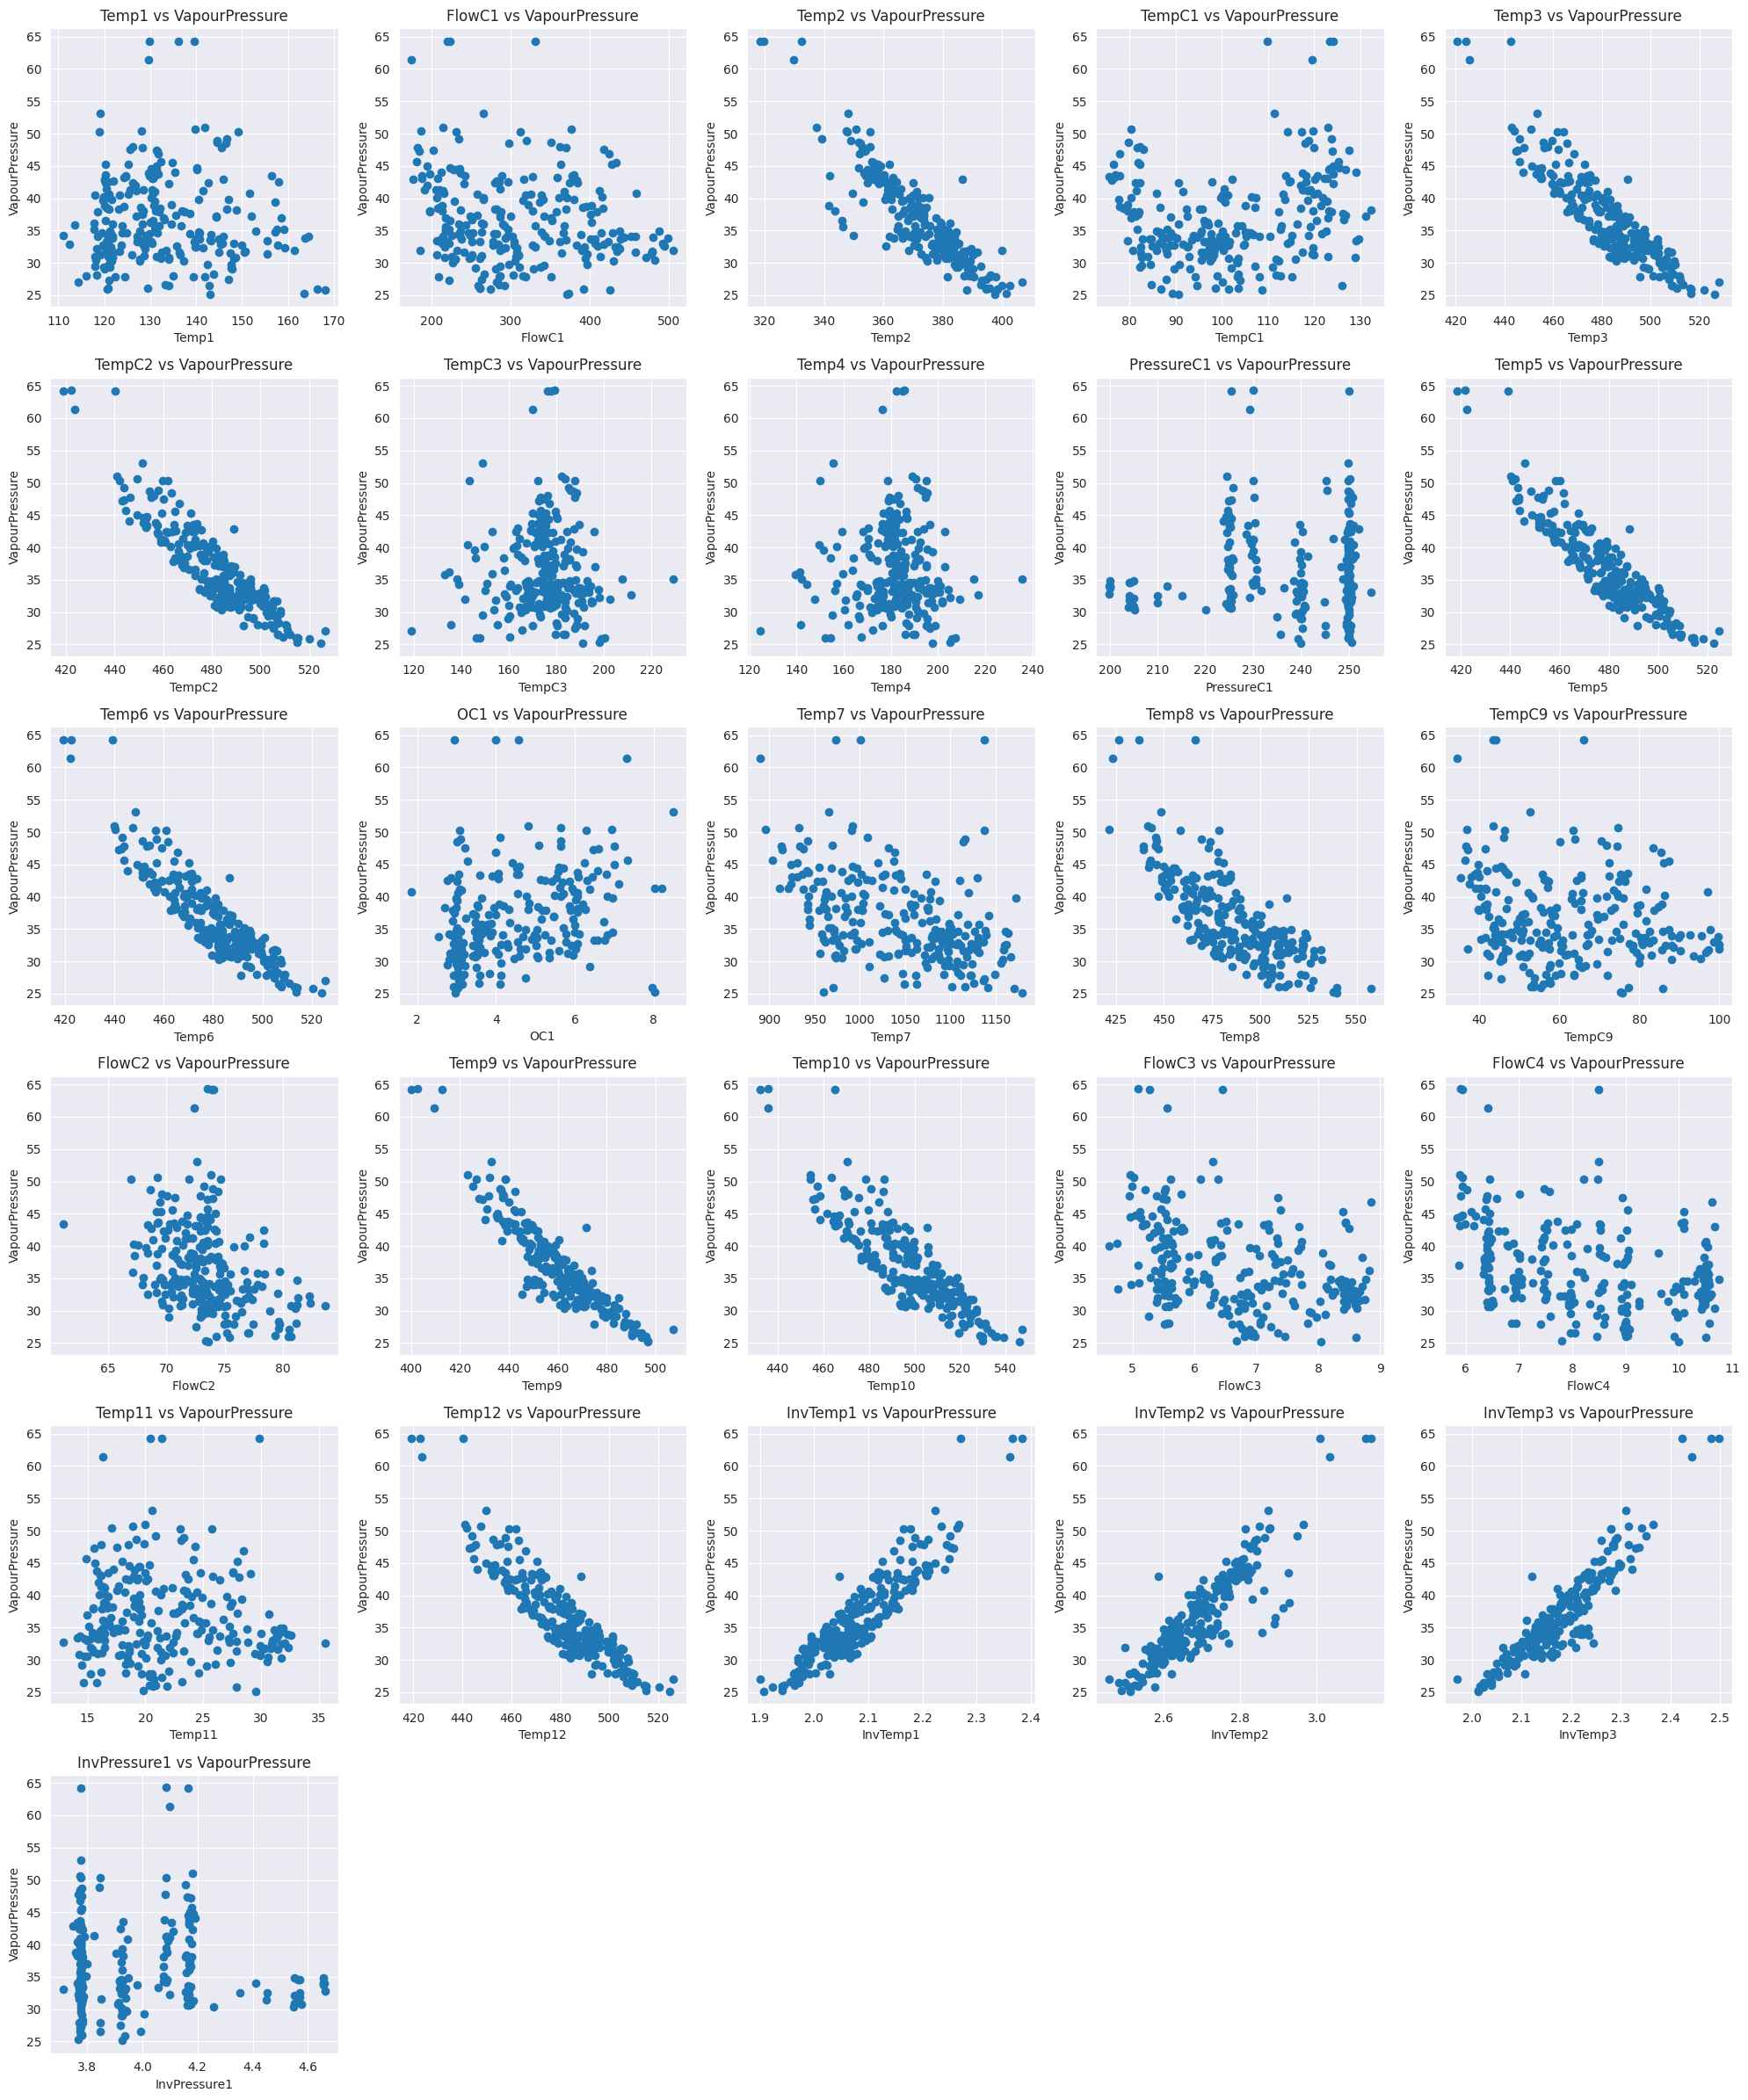

In [4]:
import matplotlib.pyplot as plt 

cols = ['Temp1', 'FlowC1', 'Temp2', 'TempC1', 'Temp3', 'TempC2', 'TempC3', 'Temp4', 'PressureC1', 'Temp5', 'Temp6', 'OC1', 'Temp7', 'Temp8', 'TempC9', 'FlowC2', 'Temp9', 'Temp10', 'FlowC3', 'FlowC4', 'Temp11', 'Temp12', 'InvTemp1', 'InvTemp2', 'InvTemp3', "InvPressure1"]
fig, axes = plt.subplots(6, 5, figsize=(20, 24))
axes_flat = axes.flatten()
for i, col in enumerate(cols):
    axes_flat[i].scatter(data[col], data['VapourPressure'])
    axes_flat[i].set_title(f'{col} vs VapourPressure')
    axes_flat[i].set_xlabel(col)
    axes_flat[i].set_ylabel('VapourPressure')
for j in range(i+1, 30):
    axes_flat[j].set_visible(False)
fig.tight_layout()
plt.show()

There is a clear relationship between the temperature measurements and vapor pressure. From thermodynamics, we know that the Antoine Equation relates vapor pressure to the inverse temperature.
$$
ln(P^{*}) = A-\frac{B}{T+C}
$$

It is also apparent that the InvTemp3 data has the most linear relationship with the Vapor pressure.

For my project, I will create a model using linear regression on the InvTemp3 vs VapourPressure data and use this model to create a prediction for the VapourPressure. Then, I will construct a neural network in two ways using this empirical model and an additional neural network that doesn't use the empirical model. For the first neural network, I will add a column to my dataframe that contains the prediction from my empirical model. By doing this, the neural network should learn that this column has a strong correlation with the correct Vapor Pressure. For the second neural network, I will predict the delta between the empirical prediction and the experimentally measured vapor pressure. The additional neural network that doesn't use the empirical model will serve as the "control" in this "experiment" to see if applying domain specific knowledge will improve the performance of the model.

Let's use PCA to reduce the dimensionality of the data.
First, we will need to classify the VapourPressure as on-specification or off-specification. Because this is an anonymous dataset, we will assume that any VapourPressure under 40 is on-specification. On-specification will correspond to 1 and off-specification will correspond to 0.

In [5]:
data['Condition'] = (data['VapourPressure'] < 40).astype(int)

data.head()

Date     Temp1    FlowC1     Temp2    TempC1     Temp3    TempC2  \
0  2000-08-21  139.9857  432.0636  377.8119  100.2204  492.1353  490.1459   
1  2000-08-23  131.0470  487.4029  371.3060  100.2297  482.2100  480.3128   
2  2000-08-26  118.2666  437.3516  378.4483  100.3084  488.7266  487.0040   
3  2000-08-29  118.1769  481.8314  378.0028   95.5766  493.1481  491.1137   
4  2000-08-30  120.7891  412.6471  377.8871   92.9052  490.2486  488.6641   

     TempC3     Temp4  PressureC1  ...  FlowC3   FlowC4   Temp11    Temp12  \
0  180.5578  187.4331    215.0627  ...  8.6279  10.5988  30.8983  489.9900   
1  172.6575  179.5089    205.0999  ...  8.7662  10.7560  31.9099  480.2888   
2  165.9400  172.9262    205.0304  ...  8.5319  10.5737  29.9165  486.6190   
3  167.2085  174.2338    205.2561  ...  8.6260  10.6695  30.6229  491.1304   
4  167.0326  173.9681    205.0883  ...  8.5939  10.4922  29.4977  487.6475   

   InvTemp1  InvTemp2  InvTemp3  InvPressure1  VapourPressure  Condition  
0    2.0409    2.6468    2.1681        4.3524         32.5026          1  
1    2.0821    2.6932    2.2207        4.5497         34.8598          1  
2    2.0550    2.6424    2.1796        4.5511         32.1666          1  
3    2.0361    2.6455    2.1620        4.5464         30.4064          1  
4    2.0507    2.6463    2.1704        4.5499         30.9238          1  

[5 rows x 29 columns]

In [6]:
X = data.iloc[:, 2:-2].values
Y = data.iloc[:, -1].values

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

Reduce the dimensionality of the data using pca.

[Text(0.5, 1.0, 'Distillate Vapour Pressure')]

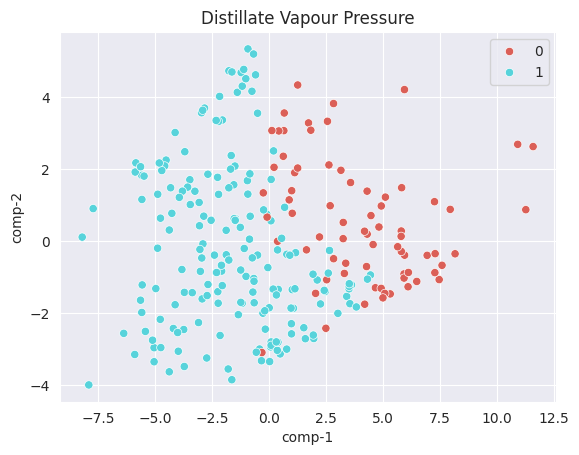

In [8]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=3) 
z = pca.fit_transform(X)

df = pd.DataFrame()
df["y"] = Y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
df["comp-3"] = z[:,2]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="Distillate Vapour Pressure")

We can perform Non-linear Dimensionality Reduction using TSNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 253 samples in 0.000s...
[t-SNE] Computed neighbors for 253 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 253 / 253
[t-SNE] Mean sigma: 2.015046
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.473579
[t-SNE] KL divergence after 1550 iterations: 0.400364


[Text(0.5, 1.0, 'Distillate Vapour Pressure')]

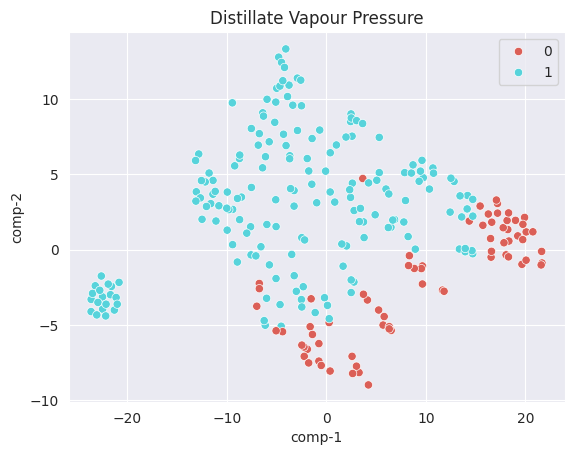

In [9]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, verbose=1, random_state=123, n_iter=2000, learning_rate='auto', perplexity=30)
z = tsne.fit_transform(X)
df = pd.DataFrame()
df["y"] = Y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="Distillate Vapour Pressure")

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, Y,
                     test_size=0.20,
                     stratify=Y,
                     random_state=1)

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=10),
                        LogisticRegression())

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.882
